In [1]:
import sys
import os

# Absolute path to your module's directory
module_path = os.path.abspath('/localscratch/zippoema/git/HPA/src/')
if module_path not in sys.path:
    sys.path.insert(0, module_path)

import hpa
import hpa.util

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:160: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import gsd.hoomd 
from sklearn import cluster as cl
from scipy.optimize import curve_fit

In [3]:
plt.style.use('default')
plt.style.use('/localscratch/zippoema/md_plots/rates_plot.mplstyle')

In [4]:
path_200 = '/localscratch/zippoema/project_ness/simulations/200-tdp43_CAL3/'
path_ss = '/localscratch/zippoema/project_ness/simulations/search_steadystate/'
path_work = '/localscratch/zippoema/working_dir/'

## Compute s(c0_{in}) and s(c0_{out})

In [147]:
def compute_Gamma_in(input_file, ser_i, eps=1.0, min_sample=2):
    tr = gsd.hoomd.open(input_file+'dump.gsd', 'r')
    c = np.loadtxt(input_file+'contacts.txt')
    
    c_p = c[c[:, 2] == 1]
    c_dp = c[c[:, 2] == -1]
    times_p = np.rint(c_p[:,0]/200000).astype(int)
    times_dp = np.rint(c_dp[:,0]/200000).astype(int)
    
    count_p = 0
    in_out = np.zeros((len(tr)+1,len(ser_i)))
    frame = gsd.hoomd.open(input_file+'start.gsd', 'r')[0]
    positions = frame.particles.position
    type_ids = frame.particles.typeid[:30800]
    db = cl.DBSCAN(eps=eps, min_samples=min_sample).fit(positions)
    labels = db.labels_
    values, counts = np.unique(labels[:30800], return_counts=True)
    condensate_idx = values[np.argmax(counts)]
    in_out[0] = labels[ser_i]==condensate_idx
    
    for i, frame in enumerate(tr):
        positions = frame.particles.position
        type_ids = frame.particles.typeid[:30800]
        db = cl.DBSCAN(eps=eps, min_samples=min_sample).fit(positions)
        labels = db.labels_
        values, counts = np.unique(labels[:30800], return_counts=True)
        condensate_idx = values[np.argmax(counts)]
        in_out[i+1] = labels[ser_i]==condensate_idx
    
    count_p = 0
    for i, tt in enumerate(times_p):
        ser_index = np.where(ser_i==c_p[i,1])[0][0]
        count_p += int(in_out[tt,ser_index])
        if not in_out[tt,ser_index]:
            print(i, tt, c_p[i,1], c_p[i,5])
    
    count_dp = 0
    for i, tt in enumerate(times_dp):
        ser_index = np.where(ser_i==c_dp[i,1])[0][0]
        count_dp += int(in_out[tt,ser_index])
    
    return count_dp - count_p

In [148]:
ser_i = np.array([266, 273, 292, 305, 317, 332, 333, 342, 347, 350, 369, 373, 375, 377, 379, 387, 389, 393, 395, 403, 404, 407, 409, 410])-260-1 
ser_i = np.array([ ser_i+154*j for j in range(200) ]).flatten()



In [152]:
delta_n = 0
nsims = 30
for s in tqdm(range(1,nsims+1)):
    input_file = path_work+f'no_driving_slab/compute_gamma_slab_200-tdp43-lcd_2-ck1d-open_10-pp3/sim{s}_sh_slab_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_'
    delta_n += compute_Gamma_in(input_file, ser_i, eps=1.0, min_sample=2)
delta_n /= nsims

 13%|█████████                                                           | 4/30 [00:24<02:40,  6.16s/it]

5 5 13684.0 6.0


 17%|███████████▎                                                        | 5/30 [00:30<02:33,  6.14s/it]

24 22 26686.0 9.0
45 41 198.0 7.0


 43%|█████████████████████████████                                      | 13/30 [01:20<01:44,  6.16s/it]

33 35 26574.0 1.0


 50%|█████████████████████████████████▌                                 | 15/30 [01:32<01:31,  6.09s/it]

28 30 3222.0 1.0
30 31 22618.0 1.0
36 39 27109.0 1.0


100%|███████████████████████████████████████████████████████████████████| 30/30 [03:04<00:00,  6.14s/it]


In [153]:
delta_n

-14.833333333333334

## Compute diffusion coefficient in dilute

In [8]:
dtimes, msd = hpa.util.compute_msd('/localscratch/zippoema/project_ness/analysis/compute_diffusion_dilute/sim_single-tdp43-lcd/sim_p-tdp43_dump_unwrapped.gsd')

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


In [24]:
def linear(x,a,b):
    return x*a+b

In [29]:
popt, pcov = curve_fit(linear, dtimes[:30],msd[:30])

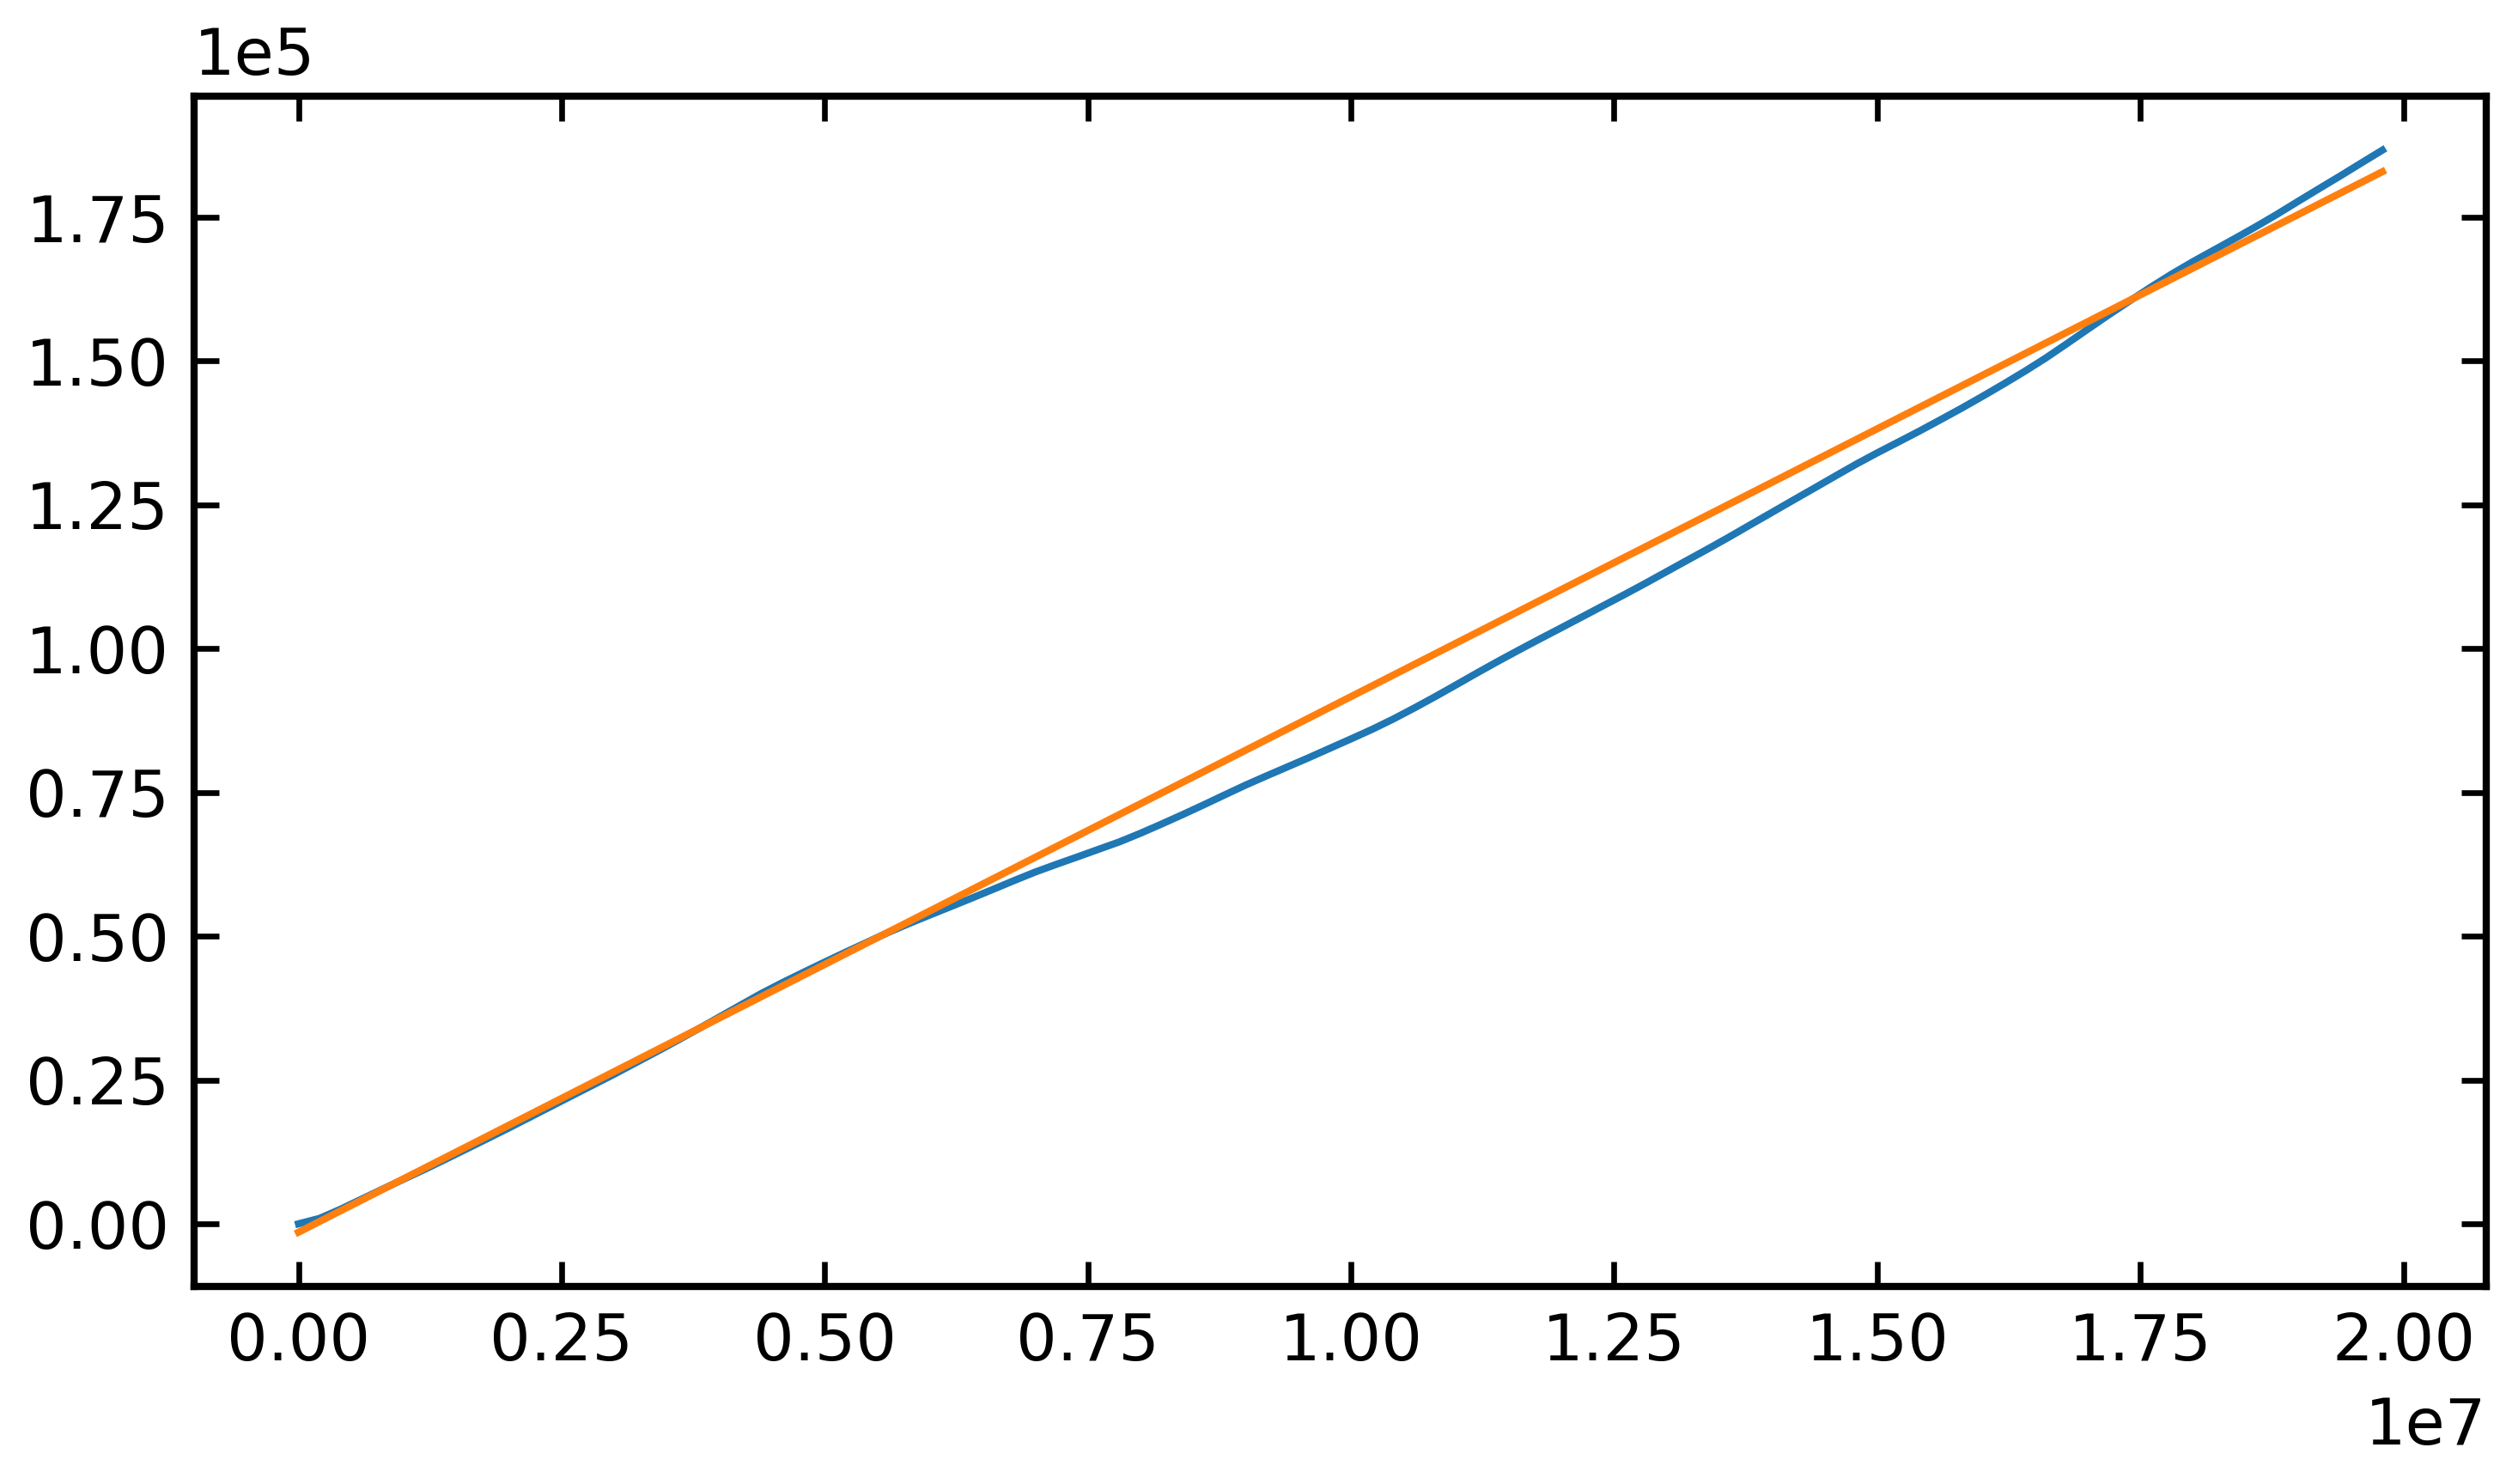

In [33]:
plt.plot(dtimes[:100],msd[:100])
plt.plot(dtimes[:100], linear(dtimes[:100], *popt))
#plt.xscale('log')
#plt.yscale('log')

In [28]:
popt, np.sqrt(pcov.diagonal())

(array([ 9.24003880e-03, -3.33066868e+03]),
 array([5.50520663e-05, 6.30916865e+02]))

In [12]:
dtimes, rg = hpa.util.compute_radius_of_gyration_from_gsd('/localscratch/zippoema/project_ness/analysis/compute_diffusion_dilute/sim_single-tdp43-lcd/sim_p-tdp43_dump_centered.gsd')

In [13]:
np.mean(rg), np.std(rg)/np.sqrt(len(dtimes)-1)

(2.9585966079235075, 0.03278226613549391)

# Compute concentrations in equilibruim

In [39]:
def compute_density_profile(gsd_file, axis=2, nbins=100, group=None):
    """
    Compute the density profile along a specified axis for a centered trajectory.

    Parameters
    ----------
    gsd_file : str
        Path to the GSD trajectory file.
    axis : int
        Axis along which to compute the profile: 0=x, 1=y, 2=z.
    nbins : int
        Number of bins along the axis.
    group : list of int or None
        Particle indices to include. If None, include all particles.

    Returns
    -------
    bin_centers : np.ndarray
        Center coordinates of bins along the axis.
    density : np.ndarray
        Average particle density in each bin.
    """
    traj = gsd.hoomd.open(gsd_file, 'rb')
    n_particles = traj[0].particles.N

    if group is None:
        group = np.arange(n_particles)
    else:
        group = np.array(group)

    # Collect all positions along the chosen axis
    positions = []
    for frame in traj:
        pos = frame.particles.position[group, axis]
        positions.append(pos)
    positions = np.concatenate(positions)  # all frames

    # Determine bin edges
    zmin, zmax = positions.min(), positions.max()
    bins = np.linspace(zmin, zmax, nbins + 1)

    # Compute histogram
    counts, edges = np.histogram(positions, bins=bins)

    # Convert to density: counts per bin volume
    bin_width = edges[1] - edges[0]
    # For a 1D profile along axis, volume = bin_width * box area perpendicular
    # Approximate box area using first frame
    box = traj[0].configuration.box[:3]
    if axis == 0:
        area = box[1] * box[2]
    elif axis == 1:
        area = box[0] * box[2]
    else:
        area = box[0] * box[1]

    density = counts / (len(traj) * area * bin_width)  # average over frames
    bin_centers = 0.5 * (edges[:-1] + edges[1:])

    return bin_centers, density

In [154]:
bin_centers, density = compute_density_profile(path_work+'no_driving_slab/sim_eq_slab_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_eq_slab_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_dump_centered.gsd',
                                               axis=2, nbins=800)


/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


In [155]:
bin_centers_tdp, density_tdp = compute_density_profile(path_work+'no_driving_slab/sim_eq_slab_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_eq_slab_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_dump_centered.gsd',
                                               axis=2, nbins=800, group=[i for i in range(30800)])


In [156]:
bin_centers_ck1d, density_ck1d = compute_density_profile(path_work+'no_driving_slab/sim_eq_slab_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_eq_slab_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_dump_centered.gsd',
                                               axis=2, nbins=200, group=[i for i in range(30800,30800+292+292)])


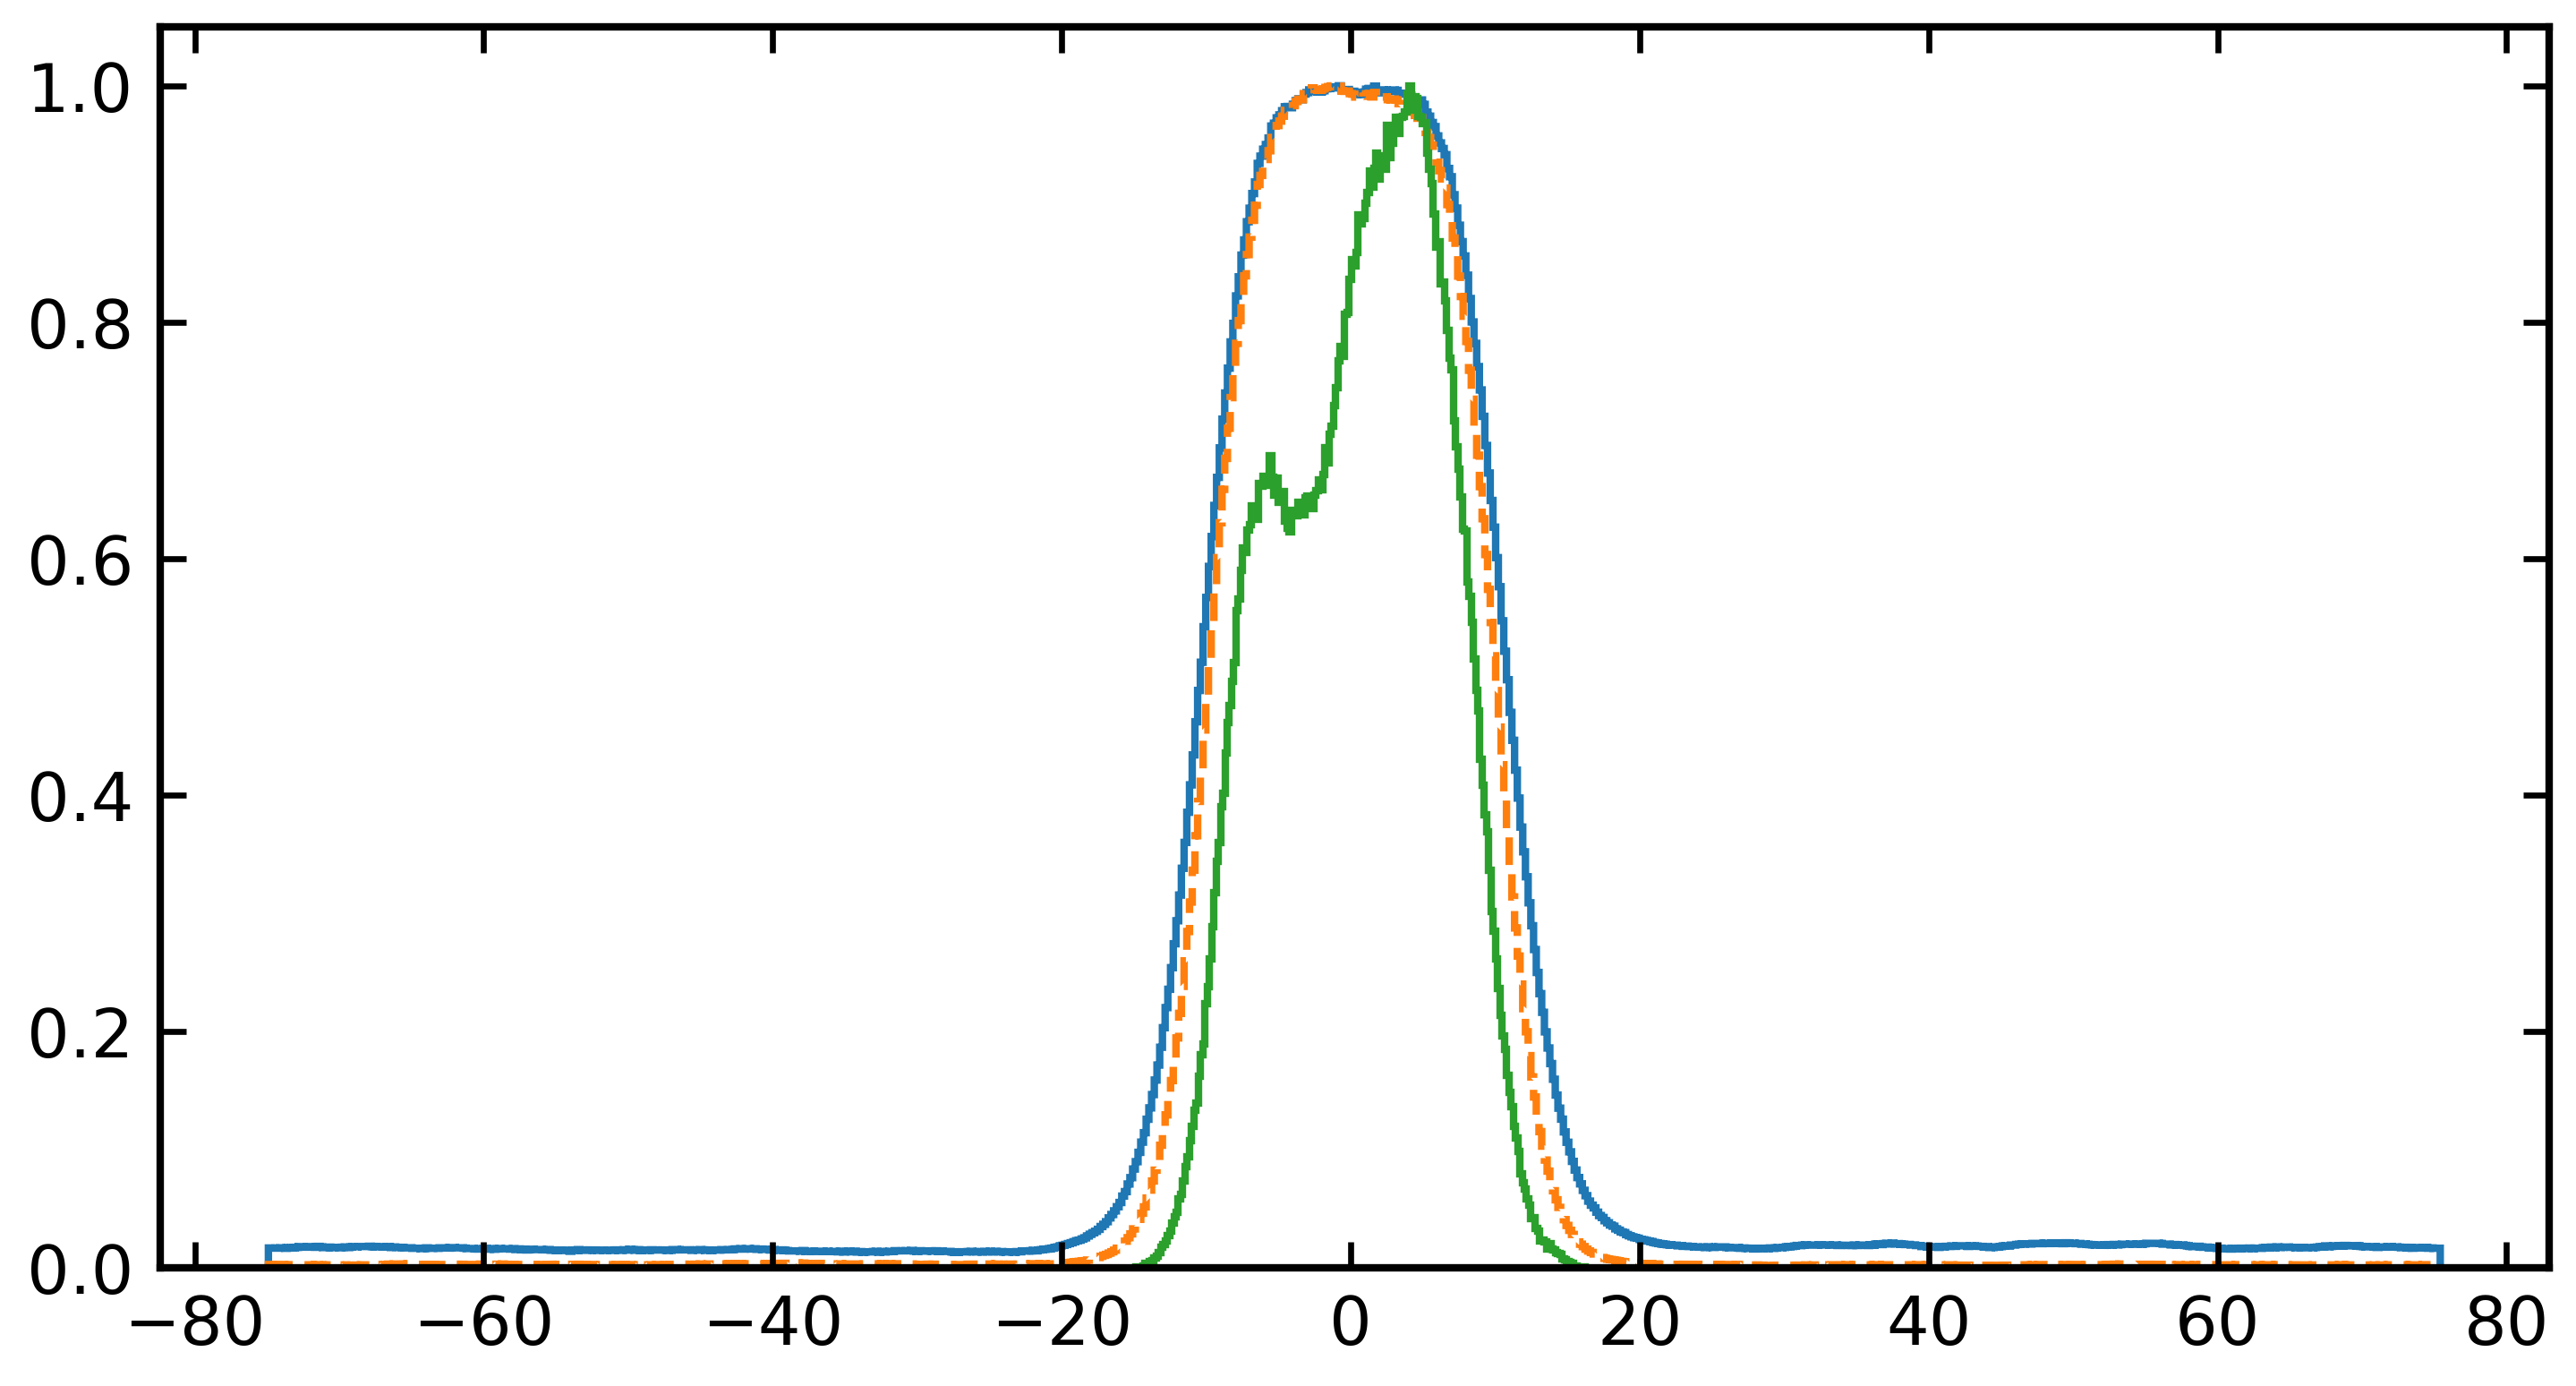

In [157]:
plt.stairs(density/np.max(density), np.append(bin_centers,bin_centers[-1]+0.5))
plt.stairs(density_tdp/np.max(density_tdp), np.append(bin_centers_tdp,bin_centers_tdp[-1]+0.5), ls='--')
plt.stairs(density_ck1d/np.max(density_ck1d), np.append(bin_centers_ck1d,bin_centers_ck1d[-1]+0.5))

In [158]:
def tanh_general(x,a,b,c,d):
    return a+b*np.tanh(c*(x-d))

In [159]:
popt_r, pcov_r = curve_fit(tanh_general, bin_centers_tdp[int(len(bin_centers_tdp)/2):], density_tdp[int(len(bin_centers_tdp)/2):], p0=[1.5, -1.49, 0.21, 8])
popt_l, pcov_l = curve_fit(tanh_general, bin_centers_tdp[:int(len(bin_centers_tdp)/2)], density_tdp[:int(len(bin_centers_tdp)/2)], p0=[1.5, 1.5, 0.21, -8])

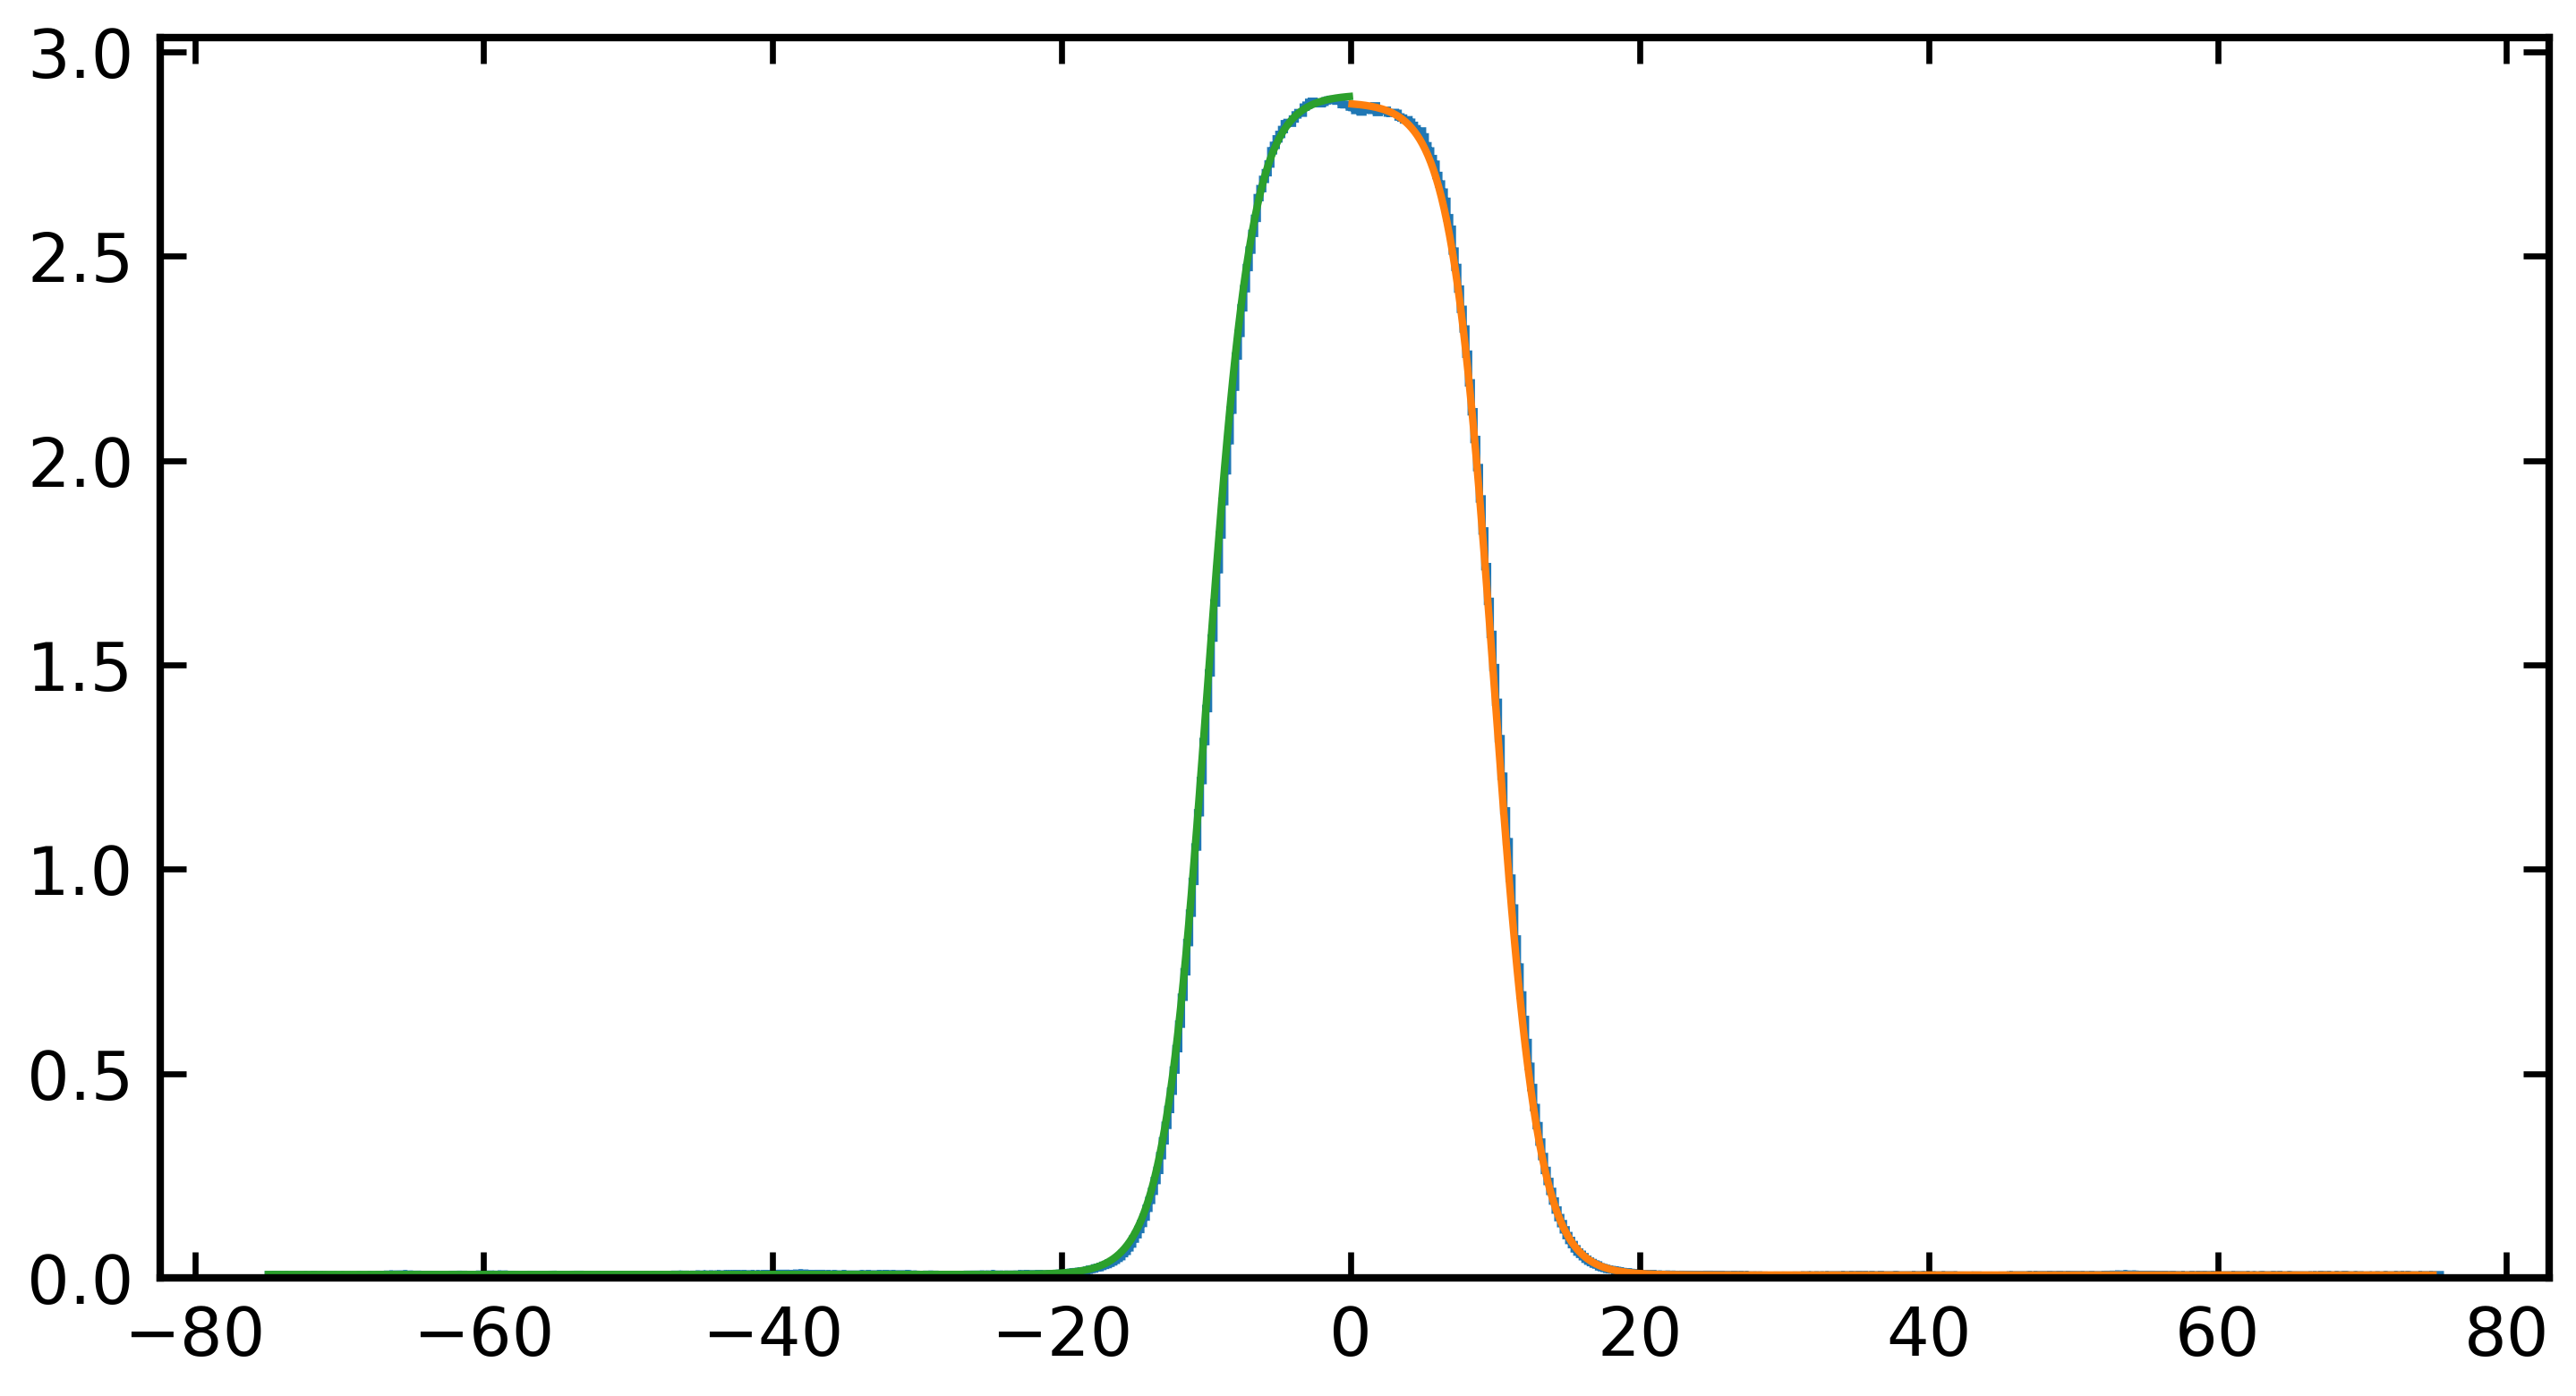

In [160]:
plt.stairs(density_tdp, np.append(bin_centers_tdp,bin_centers_tdp[-1]+0.5))
plt.plot( bin_centers_tdp[int(len(bin_centers_tdp)/2):], tanh_general(bin_centers_tdp[int(len(bin_centers_tdp)/2):], *popt_r) )
plt.plot( bin_centers_tdp[:int(len(bin_centers_tdp)/2)], tanh_general(bin_centers_tdp[:int(len(bin_centers_tdp)/2)], *popt_l) )


In [161]:
c0_in = (popt_r[0]+np.abs(popt_r[1]) + popt_l[0]+np.abs(popt_l[1]))/2
c0_in

2.8859140926811824

In [162]:
c0_out = (popt_r[0]-np.abs(popt_r[1]) + popt_l[0]-np.abs(popt_l[1]))/2
c0_out

0.007226480664372259

In [163]:
w = (1/popt_r[2] + 1/popt_l[2])/2
w

3.0291246772039377